[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/repos-especializacion-UdeA/trabajo-final_AA1/blob/main/notebooks_pasos_previos/04_arboles_decision_clasificacion.ipynb)

# Árboles de Decisión Clasificación

## Autores

* Jairo Agudelo M.
* Henry Arcila.

## Descripción corta del dataset

El dataset a trabajar [db1_rms_prep.csv](./datasets_tarea/db1_rms_prep.csv) es uno de los dataset resultantes de la etapa previa de preparacion del dataset ([link](01_preparacion_dataset_clasificacion.ipynb)). Cada entrada de la base de datos contiene los valores RMS de cada uno de los 10 sensores EMG para una ventana de tiempo de 30 muestras de señal y la postura a la cual se asocia esta venta. A continuación se describen cada una de las columnas de la muestra.

Esta base de datos se describe a continuación:

| Columna               | Descripción                                       | Ejemplo   |
|:----------------------|:--------------------------------------------------|:----------|
| `emg1`                | Valor RMS sensor 1                                | 0.052510  | 
| `emg2`                | Valor RMS sensor 2                                | 0.002414  |	
| `emg3`                | Valor RMS sensor 3                                | 0.002445  |
| `emg4`                | Valor RMS sensor 4                                | 0.002417  |
| `emg5`                | Valor RMS sensor 5                                | 0.002400  |
| `emg6`                | Valor RMS sensor 6                                | 0.006204  |
| `emg7`                | Valor RMS sensor 7                                | 0.0024    |
| `emg8`                | Valor RMS sensor 8                                | 0.041218  |
| `emg9`                | Valor RMS sensor 9                                | 0.0024    |
| `emg1p`               | Valor RMS sensor 10                               | 0.019526  |
| `label`               | Numero de la postura realizada  (1 - 12)          | 5         |

Este dataset sera empleado para realizar el entrenamiento y test del modelo.

## Objetivo a desarrollar

> Utilizar el metodo de clasificación usando arboles de decisión para identificar el tipo de postura de mano asociado a una señal electromiográfica superficial, a partir de una muestra localizada en una ventana de tiempo.

## Resumen del proceso realizado

To Do...

## Desarrollo de experimentos

## 1. Librerias y configuraciones previas


In [1]:
# Verificacion de librerias necesarias antes de empezar
try:
    import scipy.io
except ImportError:
    !pip install scipy

try:
    import imblearn
except ImportError:
    !pip install imblearn

In [2]:
# Determinacion si el archivo se va a ejecutar desde colab o local y configuracion de los elementos necesarios para la ejecucion
import sys
import os

# Path del notebook
notebook_path = "."
print(notebook_path)
try:
    import google.colab
    !git clone https://github.com/repos-especializacion-UdeA/trabajo-final_AA1.git
    %cd /content/trabajo-final_AA1/notebooks_pasos_previos   
    %pwd
    ruta_base = '/content/trabajo-final_AA1/notebooks_pasos_previos/'
    sys.path.append(ruta_base)
except ImportError:
    print("El notebook no se está ejecutando en Google Colab.")
    ruta_base = './'

.
El notebook no se está ejecutando en Google Colab.


In [23]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np


# Almacenar en caché los resultados de funciones en el disco
# ==============================================================================
import joblib


# Gestion de librerias
# ==============================================================================
from importlib import reload


# Matemáticas y estadísticas
# ==============================================================================
import math


# Preprocesado y modelado
# ==============================================================================
import math

#Separar los datos entrenamiento y prueba
from sklearn.model_selection import train_test_split


#Escalar Variables
from sklearn.preprocessing import MinMaxScaler


#Evaluación del modelo
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score


#Creación de modelo
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.tree import export_text


#configuracion de hiperparámetros
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## 2. Funciones

In [4]:
#reload(utils.funciones)

# Funciones externas
# ==============================================================================
from utils.funciones1 import multiple_plot, plot_roc_curve

## 3. Carga del dataset

In [5]:
#Se crea un dataframe d con los datos obtenidos de archivo de entrada
DATA_PATH = './datasets_tarea/'
d=pd.read_csv(DATA_PATH + 'db1_rms_prep.csv')

In [6]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16250 entries, 0 to 16249
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   emg_1   16250 non-null  float64
 1   emg_2   16250 non-null  float64
 2   emg_3   16250 non-null  float64
 3   emg_4   16250 non-null  float64
 4   emg_5   16250 non-null  float64
 5   emg_6   16250 non-null  float64
 6   emg_7   16250 non-null  float64
 7   emg_8   16250 non-null  float64
 8   emg_9   16250 non-null  float64
 9   emg_10  16250 non-null  float64
 10  label   16250 non-null  int64  
dtypes: float64(10), int64(1)
memory usage: 1.4 MB


## 4. Visualización de datos

### Variables de entrada

In [7]:
#Lista de variables categóricas
catCols = d.select_dtypes(include = ["object", 'category']).columns.tolist()

d[catCols].head(2)

""
0
1


In [8]:
#Lista de variables numéricas

numCols=d.select_dtypes(include = ['float64','float64','int32','int64']).columns.tolist()

d[numCols].head(2)

,emg_1,emg_2,emg_3,emg_4,emg_5,emg_6,emg_7,emg_8,emg_9,emg_10,label
0,0.516068,0.580968,0.173756,0.068346,0.031557,0.002400,0.002447,0.049063,0.608643,0.006596,0
1,0.123792,0.290991,0.007430,0.002466,0.002441,0.002399,0.002422,0.008951,0.002594,0.002414,0


In [9]:
##Visualización de frecuencia de instancias para variables categóricas
#multiple_plot(3, d , catCols, None, 'countplot', 'Frecuencia de instancias para variables categóricas',30)

In [10]:
##Visualización de variables numéricas
#multiple_plot(1, d , numCols, None, 'scatterplot', 'Relación entre las variables numéricas',30)

In [11]:
#Eliminar la variable de salida de la lista de variable numéricas
numCols.remove('label')

### Variable de salida

In [12]:
# Distriución de la variable de salida

d.groupby('label').label.count().sort_values(ascending=False)

label
0     1250
1     1250
2     1250
3     1250
4     1250
5     1250
6     1250
7     1250
8     1250
9     1250
10    1250
11    1250
12    1250
Name: label, dtype: int64

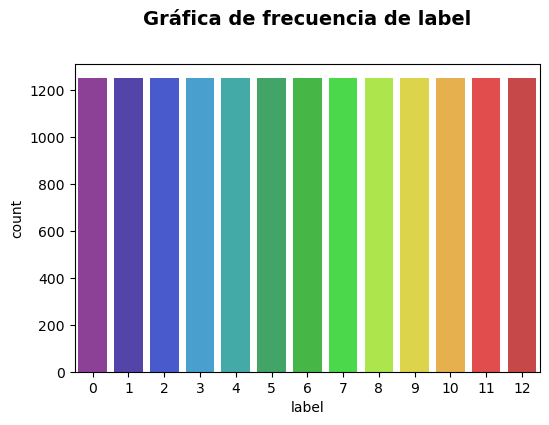

In [13]:
##Visualización de la variable de salida
multiple_plot(1, d , None, 'label', 'countplot', 'Gráfica de frecuencia de label',0)

## 5. Transformación de datos

### Creación de variables Dummies 

In [14]:
# Aplicación de la función de usuario Dummies: one-hot encoding

d =pd.get_dummies(d, drop_first=1)

d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16250 entries, 0 to 16249
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   emg_1   16250 non-null  float64
 1   emg_2   16250 non-null  float64
 2   emg_3   16250 non-null  float64
 3   emg_4   16250 non-null  float64
 4   emg_5   16250 non-null  float64
 5   emg_6   16250 non-null  float64
 6   emg_7   16250 non-null  float64
 7   emg_8   16250 non-null  float64
 8   emg_9   16250 non-null  float64
 9   emg_10  16250 non-null  float64
 10  label   16250 non-null  int64  
dtypes: float64(10), int64(1)
memory usage: 1.4 MB


## 6. Creación del modelo

### Dividir el conjunto de datos

In [15]:
#Se establece las variables de entrada 'X' y la variable de salida 'y'
X = d.drop(columns ='label')
y = d['label']

In [16]:
# Se crean los datasets de entrenamiento y prueba para las variables de entrada y salida 

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1), 
                                        train_size   = 0.8,
                                        random_state = 123,
                                        shuffle      = True
                                    )

### Escalar Variables

In [17]:
#Se establecen las variables numéricas a escalar

#Num_vars se le asigna la lista con las variables numerivas para posteriormente escalarlas
num_vars = numCols

print(num_vars)

['emg_1', 'emg_2', 'emg_3', 'emg_4', 'emg_5', 'emg_6', 'emg_7', 'emg_8', 'emg_9', 'emg_10']


In [18]:
#Escalar Variables númericas

pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Se crea un objeto MinMaxScaler
scaler = MinMaxScaler()

# Se escalan los valores del dataset entrenamiento y prueba de las columnas numéricas
X_train[num_vars] = scaler.fit_transform(X_train[num_vars])
X_test[num_vars] = scaler.transform(X_test[num_vars])

X_train[num_vars].head(2)

,emg_1,emg_2,emg_3,emg_4,emg_5,emg_6,emg_7,emg_8,emg_9,emg_10
6381,0.0018,0.0126,0.0777,0.0180,0.0043,0.0066,0.0824,0.0421,0.2490,0.0688
6222,0.0035,0.1545,0.0999,0.0290,0.2317,0.1491,0.2492,0.3142,0.1080,0.1018


### Creación del modelos

- **criterion** (default=”gini”): Función para medir la calidad de la partición: “gini”, “entropy”, “log_loss”.
    - Gini es más rápido de calcular que la entropía, tiende a favorecer la partición de nodos que contienen clases mayoritarias en el conjunto de datos.
    - La entropía tiende a favorecer la creación de árboles más equilibrados y puede ser más útil cuando se tienen múltiples clases con distribuciones más uniformes.
Aunque ligeramente más costosa computacionalmente que Gini,
- **max_depth** (default=None): maxima profundidad del árbol
- **min_samples_split**(default=2): Mínimo de ejemplos para separar un nodo interno 
- **min_samples_leaf**(default=1): Mínimo numero de ejemplos requeridos en un nodo hoja
- **ccp_alpha**: Parámetro de complejidad usado para el  Minimal Cost-Complexity de poda. Es un algoritmo que se usa para podar un árbol para evitar el over-fitting

In [46]:
# Creación del modelo
# ------------------------------------------------------------------------------
modelDtree1 = DecisionTreeClassifier(
            max_depth         = None,
            criterion         = 'gini',
            random_state      = 123,
            min_samples_leaf = 1,
            min_samples_split = 2
          )

# Entrenamiento del modelo
# ------------------------------------------------------------------------------
modelDtree1.fit(X_train, y_train)

DecisionTreeClassifier(random_state=123)

In [47]:
# Estructura del árbol creado
# ------------------------------------------------------------------------------
print(f"Profundidad del árbol: {modelDtree1.get_depth()}")
print(f"Número de nodos terminales: {modelDtree1.get_n_leaves()}")

# fig, ax = plt.subplots(figsize=(28, 8))


# plot = plot_tree(
#            decision_tree = modelDtree1,
#            feature_names = X.columns,
#            class_names   = True,
#            filled        = True,
#            impurity      = True,
#            fontsize      = 7,
#            ax            = ax
#       )

# Calcular el F1 score
y_pred1 = modelDtree1.predict(X_test)
f1_tree = f1_score(y_test, y_pred1, average='weighted')
print("F1 Score:", f1_tree)

Profundidad del árbol: 31
Número de nodos terminales: 2758
F1 Score: 0.6904516160814774


#### Evaluacion del modelo

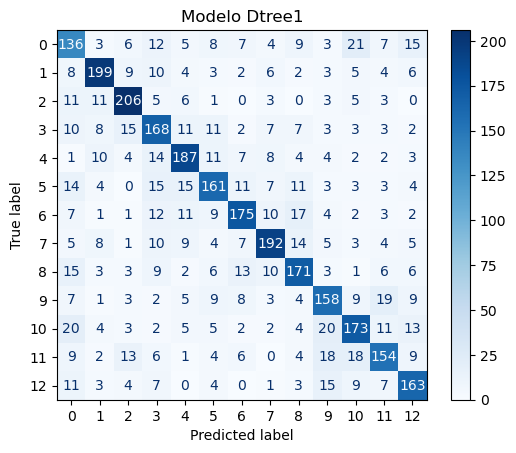

              precision    recall  f1-score   support

           0       0.54      0.58      0.56       236
           1       0.77      0.76      0.77       261
           2       0.77      0.81      0.79       254
           3       0.62      0.67      0.64       250
           4       0.72      0.73      0.72       257
           5       0.68      0.64      0.66       251
           6       0.73      0.69      0.71       254
           7       0.76      0.72      0.74       267
           8       0.68      0.69      0.69       248
           9       0.65      0.67      0.66       237
          10       0.68      0.66      0.67       264
          11       0.68      0.63      0.66       244
          12       0.69      0.72      0.70       227

    accuracy                           0.69      3250
   macro avg       0.69      0.69      0.69      3250
weighted avg       0.69      0.69      0.69      3250



In [48]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred1)

# Crear la visualización de la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))

# Mostrar la visualización
disp.plot(cmap='Blues')

# Configurar el título
plt.title('Modelo Dtree1')

# Mostrar la figura
plt.show()

# Mostrar el informe de clasificación
print(classification_report(y_test, y_pred1))

In [49]:
# Creación del modelo
# ------------------------------------------------------------------------------
modelDtree2 = DecisionTreeClassifier(
            max_depth         = None,
            criterion         = 'entropy',
            random_state      = 123,
            class_weight = 'balanced'
          )

# Entrenamiento del modelo
# ------------------------------------------------------------------------------
modelDtree2.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       random_state=123)

In [51]:
# Estructura del árbol creado
# ------------------------------------------------------------------------------


# fig, ax = plt.subplots(figsize=(28, 8))


print(f"Profundidad del árbol: {modelDtree2.get_depth()}")
print(f"Número de nodos terminales: {modelDtree2.get_n_leaves()}")

# plot = plot_tree(
#            decision_tree = modelDtree,
#            feature_names = X.columns,
#            class_names   = True,
#            filled        = True,
#            impurity      = True,
#            fontsize      = 7,
#            ax            = ax
#       )

# Calcular el F1 score
y_pred2 = modelDtree2.predict(X_test)
f1_tree2 = f1_score(y_test, y_pred2, average='weighted')
print("F1 Score:", f1_tree2)

Profundidad del árbol: 23
Número de nodos terminales: 2669
F1 Score: 0.7191637312912574


##### Evaluación del modelo

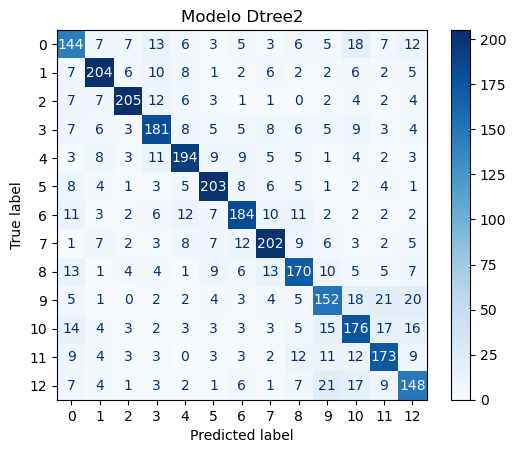

              precision    recall  f1-score   support

           0       0.61      0.61      0.61       236
           1       0.78      0.78      0.78       261
           2       0.85      0.81      0.83       254
           3       0.72      0.72      0.72       250
           4       0.76      0.75      0.76       257
           5       0.79      0.81      0.80       251
           6       0.74      0.72      0.73       254
           7       0.77      0.76      0.76       267
           8       0.70      0.69      0.69       248
           9       0.65      0.64      0.65       237
          10       0.64      0.67      0.65       264
          11       0.69      0.71      0.70       244
          12       0.63      0.65      0.64       227

    accuracy                           0.72      3250
   macro avg       0.72      0.72      0.72      3250
weighted avg       0.72      0.72      0.72      3250



In [52]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred2)

# Crear la visualización de la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))

# Mostrar la visualización
disp.plot(cmap='Blues')

# Configurar el título
plt.title('Modelo Dtree2')

# Mostrar la figura
plt.show()

# Mostrar el informe de clasificación
print(classification_report(y_test, y_pred2))

## 7. Afinando el modelo (tuning)

In [56]:
#Se establece las variables de entrada 'X' y la variable de salida 'y'

X = d.drop(columns ='label')
y = d['label']

# la validación cruzada se realiza sobre todo el dataset
X_Completo = X
y_Completo = y


In [57]:
#Escalar Variables númericas

pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Se escalan los valores del dataset entrenamiento y prueba de las columnas numéricas
X_Completo[num_vars] = scaler.fit_transform(X_Completo[num_vars])

X_Completo[num_vars].head(2)

,emg_1,emg_2,emg_3,emg_4,emg_5,emg_6,emg_7,emg_8,emg_9,emg_10
0,0.2115,0.1966,0.0405,0.0202,0.0533,0.0011,0.0004,0.0110,0.1566,0.0024
1,0.0504,0.0984,0.0017,0.0006,0.0035,0.0011,0.0004,0.0018,0.0006,0.0008


### Podado del árbol (pruning)

In [80]:
# Post pruning (const complexity pruning) por validación cruzada

# El árbol se crece al máximo posible antes de aplicar el pruning
modelTreeC= DecisionTreeClassifier(
                            max_depth         = None,
                            min_samples_split = 2,
                            min_samples_leaf  = 1,
                            random_state      = 123,
                       )


# Definir los parámetros para la búsqueda en la cuadrícula
# parameters = {'ccp_alpha': np.logspace(-6, 2, 9)} # Valores entre 0.000001 y 100 en una escala logarítmica
parameters = {
    'criterion': ['entropy','gini'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
}

# Definimos las metricas sobre las que queremos evaluar
# metricas = ['accuracy', 'f1', 'precision'] 
metricas = 'accuracy'

# definicion de la variable con el número de pliegues
CV = 10

# Búsqueda por validación cruzada
grid_TreeC = GridSearchCV(        
        estimator =  modelTreeC,
        param_grid = parameters,
        scoring    = metricas,
        cv         = CV,
        refit      = True,
        return_train_score = True
        
      )

grid_TreeC.fit(X_Completo, y_Completo)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=123),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             return_train_score=True, scoring='accuracy')

In [65]:
#fig, ax = plt.subplots(figsize=(6, 3.84))
#scores = pd.DataFrame(grid_TreeC.cv_results_)

# Variacion de ccp_alpha
#ax.set_xscale('log')
#scores.plot(x='param_ccp_alpha', y='mean_test_score', yerr='std_test_score', ax=ax)
#scores.plot(x='param_ccp_alpha', y='mean_test_score',  ax=ax)
#ax.set_title("Error de validacion cruzada vs hiperparámetro ccp_alpha");

In [81]:
# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid_TreeC.cv_results_)
resultados.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(10)

,param_criterion,param_max_features,param_min_samples_leaf,param_min_samples_split,mean_test_score,std_test_score,mean_train_score,std_train_score
0,entropy,None,1,2,0.7240,0.0083,1.0000,0.0000
1,entropy,None,1,5,0.7161,0.0105,0.9579,0.0016
3,entropy,None,2,2,0.7101,0.0093,0.9431,0.0011
4,entropy,None,2,5,0.7100,0.0073,0.9356,0.0012
27,gini,None,1,2,0.7070,0.0094,1.0000,0.0000
5,entropy,None,2,10,0.6985,0.0064,0.8905,0.0020
2,entropy,None,1,10,0.6985,0.0056,0.9012,0.0018
28,gini,None,1,5,0.6966,0.0072,0.9483,0.0016
7,entropy,None,4,5,0.6959,0.0081,0.8830,0.0018
6,entropy,None,4,2,0.6959,0.0081,0.8830,0.0018


In [82]:
# Mejor valor ccp_alpha encontrado
# ------------------------------------------------------------------------------
grid_TreeC.best_params_

{'criterion': 'entropy',
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [84]:
# Estructura del árbol final
# ------------------------------------------------------------------------------
modelDtree = grid_TreeC.best_estimator_
print(f"Profundidad del árbol: {modelDtree.get_depth()}")
print(f"Número de nodos terminales: {modelDtree.get_n_leaves()}")
print(f"Score: {grid_TreeC.best_score_}")

Profundidad del árbol: 20
Número de nodos terminales: 2920
Score: 0.724


In [36]:
# Creación del modelo
# ------------------------------------------------------------------------------
modelDtree = DecisionTreeClassifier(
            ccp_alpha         = grid_TreeC.best_params_["ccp_alpha"],
            random_state      = 123
          )

# Entrenamiento del modelo
# ------------------------------------------------------------------------------
modelDtree.fit(X_Completo, y_Completo)

DecisionTreeClassifier(ccp_alpha=1e-06, random_state=123)

### Guardar modelo

In [85]:
#Se guarda el modelo de Árbol de decisión
joblib.dump(modelDtree, './modelos/clasificacion/DTreeC_CV.pkl')

['./modelos/clasificacion/DTreeC_CV.pkl']

## 7. Importancia de predictores

### Importancia por pureza de nodos

In [86]:
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores = pd.DataFrame(
                            {'predictor': X.columns,
                             'importancia': modelDtree.feature_importances_}
                            )
importancia_predictores.sort_values('importancia', ascending=False).head(10)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
0,emg_1,0.1232
8,emg_9,0.1184
6,emg_7,0.1155
9,emg_10,0.1153
7,emg_8,0.1152
2,emg_3,0.0997
1,emg_2,0.0996
5,emg_6,0.0910
3,emg_4,0.0733
4,emg_5,0.0489


## Conclusiones

To Do...

#### Referencias


- Áboles de decisión
    - https://www.aprendemachinelearning.com/arbol-de-decision-en-python-clasificacion-y-prediccion/
    - https://www.cienciadedatos.net/documentos/py07_arboles_decision_python.html
    - https://www.datacamp.com/es/tutorial/decision-tree-classification-python